# **Credits**
Creator: Long Vo <br>
Date: 11/10/2022 <br>
<br>

In [61]:
import warnings
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict

## Load Data

In [62]:
train_ds = np.loadtxt('../assets/training_dataset.txt', dtype=float)
test_ds = np.loadtxt('../assets/test_dataset.txt', dtype=float)

In [63]:
def data_extract(train_data):
    data_list = list()
    label_list = list()
    for val in train_data:
        data_list.append(val[0:784])
        label_list.append(int(val[784]))
    data_list = np.array(data_list)
    label_list = np.array(label_list)
    return data_list, label_list

np.random.shuffle(train_ds)

x_train, y_train = data_extract(train_ds)
x_test, y_test = data_extract(test_ds)
# x_train = x_train / 255

In [64]:
y_train

array([7, 6, 8, ..., 7, 0, 8])

# Neural Network class (Autoencoder)

In [65]:
warnings.filterwarnings('ignore')
EPOCHS = 1100
hidden_neurons = 180

In [66]:
class NeuralNetwork():
    
    def __init__(self, input_nn: int, output_nn: int, hidden_nn: list, hidden_layers: int, learning_rate=0.01, alpha=0.5, epochs=EPOCHS, high=0.75, low=0.25):
        self.input_nn = input_nn
        self.output_nn = output_nn
        self.hidden_nn = hidden_nn
        self.hidden_layers = hidden_layers
        self.learning_rate = learning_rate
        self.alpha = alpha
        self.epochs = epochs
        self.high = high
        self.low = low
        # self.b = 1
        self.b1 = 1
        self.y_hat = OrderedDict()
        self.w1 = np.random.randn(self.hidden_nn[0], self.input_nn) * np.sqrt(1 / (self.input_nn + self.hidden_nn[0]))
        if hidden_layers < 2:
            self.w2 = np.random.randn(self.output_nn, self.hidden_nn[0]) * np.sqrt(1 / (self.output_nn + self.hidden_nn[0]))
            self.b2 = 1
        else:
            self.w_dict = dict()
            for i in range(self.hidden_layers):
                temp = 'w' + str(i + 2)
                if self.hidden_layers - i == 1:
                    self.w_dict[temp] = np.random.rand(self.output_nn, self.hidden_nn[i]) * np.sqrt(1 / (self.output_nn + self.hidden_nn[i]))
                    break
                self.w_dict[temp] = np.random.rand(self.hidden_nn[i + 1], self.hidden_nn[i]) * np.sqrt(1 / (self.hidden_nn[i + 1] + self.hidden_nn[i]))
    
        
    def get_weight(self):
        if self.hidden_layers >= 2:
            return self.w1, self.w_dict
        return self.w1, self.w2
    
    
    def sigmoid(self, x): 
        return 1.0/(1.0 + np.exp(-x))


    def deri_sigmoid(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    
    def forward_prop(self, input_ds):
        self.s1 = np.dot(input_ds, self.w1.T) + self.b1
        self.y_hat1 = self.sigmoid(self.s1)
        if self.hidden_layers < 2:
            self.s2 = np.dot(self.y_hat1, self.w2.T) + self.b2 # net input 
            self.y_hat2 = self.sigmoid(self.s2) # activation function for the output layer.
        else:
            self.s2 = np.dot(self.y_hat1, self.w_dict['w2'].T) + self.b # net input 
            self.y_hat['y_hat2'] = self.sigmoid(self.s2)
            for i in range(1, self.hidden_layers):
                temp_y = 'y_hat' + str(i + 1)
                temp_w = 'w' + str(i + 2)
                s = np.dot(self.y_hat[temp_y], self.w_dict[temp_w].T) + self.b
                temp_y = 'y_hat' + str(i + 2)
                self.y_hat[temp_y] = self.sigmoid(s)
                

    def get_output(self):
        if self.hidden_layers < 2:
            return self.y_hat2
        else:
            self.y_hat_val = list(self.y_hat.items())
            self.y_hat_value = np.array(list(self.y_hat_val[len(self.y_hat_val) - 1]))
            return np.asarray(self.y_hat_value[1])            
        
        
    def backward_prop(self, x, epochs):
        m,n = x.shape  
        if self.hidden_layers < 2:
            self.theta(self.y_hat2)
            self.output_errors = x - self.y_hat2
            
            self.d_output = self.output_errors * self.deri_sigmoid(self.y_hat2)
            # print(self.d_output.shape)
            # print(self.w2.shape)
            # print(self.y_hat1.shape)
            # temp = np.dot(self.d_output, self.w2)
            # print(temp.shape)
            self.d_hidden = self.deri_sigmoid(self.y_hat1) * np.dot(self.d_output, self.w2)
            # print(self.y_hat1.shape)
            delta_w_2 = self.learning_rate * np.dot(self.y_hat1.T, self.d_output) # Weights change for the second layer (hidden - output)           
            delta_w_1 = self.learning_rate * np.dot(x.T, self.d_hidden) # Weights change for the first layer (input - hidden)

            
            if (epochs > 1): 
                delta_w_2 += (self.alpha * self.pre_delta_w_2) 
                delta_w_1 += (self.alpha * self.pre_delta_w_1)
                self.w2 += delta_w_2.T 
                self.w1 += delta_w_1.T 
            
            self.pre_delta_w_2 = delta_w_2 # update of weights change
            self.pre_delta_w_1 = delta_w_1 # update of weights change
            
            # delta_b1 = 1 / m * np.sum(self.d_hidden) * self.learning_rate
            # delta_b2 = 1 / m * np.sum(self.output_errors) * self.learning_rate
            
            # delta_b1 = np.sum(self.d_hidden) * self.learning_rate
            # delta_b2 = np.sum(self.d_output) * self.learning_rate
            
            # if epochs > 1: #run after epoch = 1 
            #     deltaw2 += (self.alpha * self.pre_deltaw2) 
            #     deltaw1 += (self.alpha * self.pre_deltaw1)
            #     delta_b2 += (self.alpha * self.pre_delta_b2)
            #     delta_b1 += (self.alpha * self.pre_delta_b1)
            #     self.w2 += deltaw2.T # for (hidden - output)
            #     self.w1 += deltaw1.T # for (input - output)
            #     # self.b1 += delta_b1
            #     # self.b2 += delta_b2
            
            # self.pre_deltaw2 = deltaw2 # update of weights change
            # self.pre_deltaw1 = deltaw1 
            # # self.pre_delta_b2 = delta_b2 # update of bias change
            # # self.pre_delta_b1 = delta_b1
        
        else:
            w_key = ['w' + str(i + 2) for i in range(self.hidden_layers)]
            self.y_hat_val = list(self.y_hat.items())
            self.y_hat_value = np.array(list(self.y_hat_val[len(self.y_hat_val) - 1]))
            self.y_hat_val = np.array(list(self.y_hat_val))            
            self.theta(self.y_hat_value[1])            
            self.output_errors = x - self.y_hat_value[1]
            index = len(self.y_hat_val) - 1
            
            while (index >= 0):
                self.d_output = self.output_errors * self.deri_sigmoid(self.y_hat_val[index][1])
                self.d_hidden = self.deri_sigmoid(self.y_hat_val[index - 1][1]) * np.dot(self.d_output, self.w_dict[w_key[index]])

                delta_w_2 = self.learning_rate * np.dot(np.transpose(self.y_hat_val[index - 1][1]), self.d_output)
                delta_w_1 = self.learning_rate * np.dot(np.transpose(x), self.d_hidden) 

                if(epochs > 1):
                    delta_w_2 += (self.alpha * self.pre_delta_w_2)
                    delta_w_1 += (self.alpha * self.pre_delta_w_1)
                    self.w_dict[index] += delta_w_2.T 
                    self.w_dict[index] += delta_w_1.T 
                
                self.pre_delta_w_2 = delta_w_2 # update of weights change
                self.pre_delta_w_1 = delta_w_1 # update of weights change
                index -= 1
                self.theta(self.y_hat_val[index-1][1])               
                self.output_errors = self.y_hat_val[index][1] - self.y_hat_val[index-1][1]
        
        
    def theta(self, y_hat): # theta for output
        for q in y_hat:
            for idx, j in enumerate(q):
                if j >= self.high:
                    q[idx] = 1.0
                elif j <= self.low:
                    q[idx] = 0.0

# Train Autoencoder

In [67]:
def error_loss(y, yhat):
    ERRORS = 0
    for idx, x in enumerate(y):
        ERRORS += (0.5 * np.sum(((x - yhat[idx])**2)))
    return ERRORS / 784

In [68]:
nn = NeuralNetwork(784, 784, [hidden_neurons], 1)
nn.forward_prop(x_train)
training_errors = list()

In [69]:
nn.get_output().shape

(4000, 784)

In [70]:
for i in range(EPOCHS + 1):
    nn.forward_prop(x_train)
    if i % 10 == 0:
        print(f'Iteration {i}:')
        temp_output = error_loss(x_train, nn.get_output())
        training_errors.append(temp_output)
        print(f'Error fraction: {temp_output}')
    nn.backward_prop(x_train, i)

Iteration 0:
Error fraction: 910.5892734416663
Iteration 10:
Error fraction: 293.71339914932935
Iteration 20:
Error fraction: 306.7505872432775
Iteration 30:
Error fraction: 331.54960167923633
Iteration 40:
Error fraction: 306.75691668894245
Iteration 50:
Error fraction: 381.2676840101892
Iteration 60:
Error fraction: 249.394919420494
Iteration 70:
Error fraction: 171.3558556626094
Iteration 80:
Error fraction: 145.98449267876188
Iteration 90:
Error fraction: 134.01678413373105
Iteration 100:
Error fraction: 124.11443782858862
Iteration 110:
Error fraction: 109.73716069720861
Iteration 120:
Error fraction: 99.56049806334087
Iteration 130:
Error fraction: 96.52470095087993
Iteration 140:
Error fraction: 94.48866529294015
Iteration 150:
Error fraction: 90.62503301208781
Iteration 160:
Error fraction: 91.4897505890369
Iteration 170:
Error fraction: 94.38583283499375
Iteration 180:
Error fraction: 91.80211748852174
Iteration 190:
Error fraction: 88.98455879663555
Iteration 200:
Error fract

### Display for testing purpose

<AxesSubplot: >

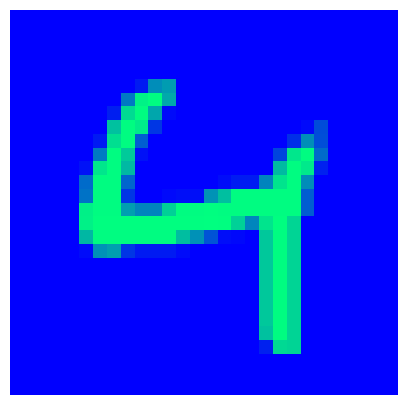

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
sns.heatmap(x_train[2499].reshape(28, 28).T, ax=ax, vmin=0, vmax=1, cmap='winter', xticklabels=False, yticklabels=False, cbar=False)

<AxesSubplot: >

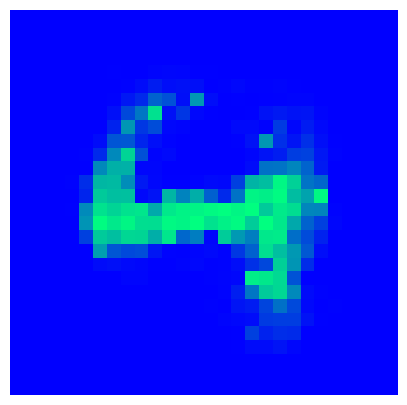

In [92]:
nn.forward_prop(x_train)
fig, ax = plt.subplots(1, 1, figsize=(5,5))
sns.heatmap(nn.get_output()[2499].reshape(28, 28).T, ax=ax, vmin=0, vmax=1, cmap='winter', xticklabels=False, yticklabels=False, cbar=False)

# Sample Output

In [93]:
def get_random_list(limit, num):
    random_list = list()
    iteration = 0
    while iteration < limit:
        r = random.randint(0, num - 1)
        if r not in random_list:
            random_list.append(r)
            iteration += 1
    return random_list


def get_index_digit(digit, data):
    index = list()
    for i, value in enumerate(data):
        if value == digit:
            index.append(i)
    return index


def get_error_digit(y, yhat, digits):
    ERRORS = 0
    for digit in digits:
        ERRORS += (0.5 * np.sum(((y[digit] - yhat[digit])**2)))                      
    return ERRORS / 784

In [94]:
random_sample = get_random_list(8, hidden_neurons)
print(random_sample)

[84, 20, 23, 166, 88, 4, 24, 138]


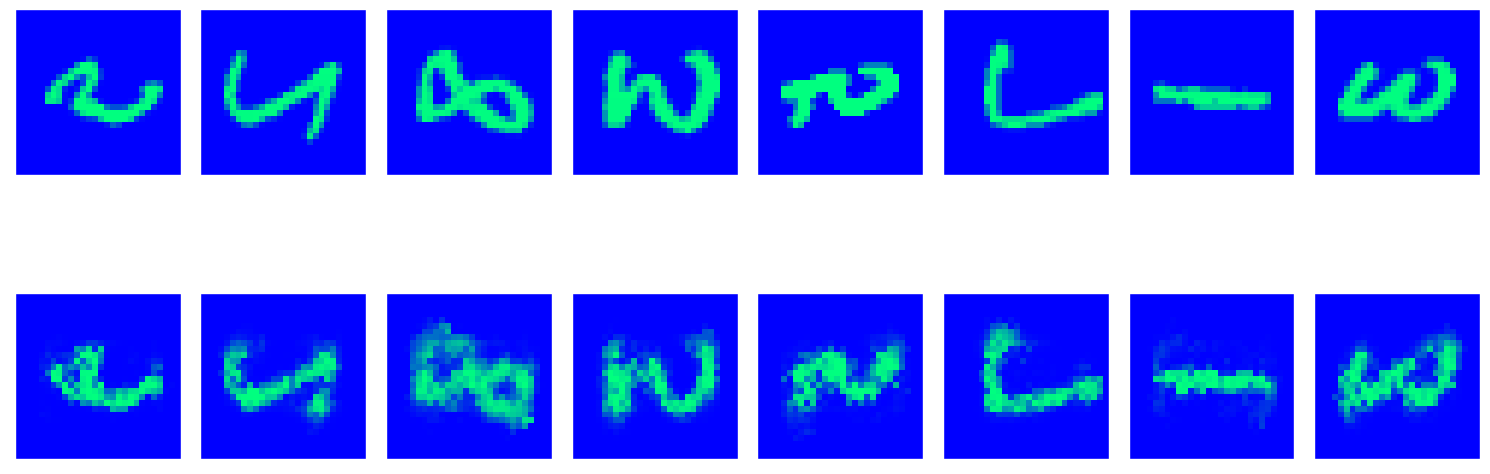

In [95]:
nn.forward_prop(x_test)
output_test = nn.get_output()
fig, ax = plt.subplots(2, 8, figsize=(15, 7))
plt.style.use('ggplot')
for i in range(len(random_sample)):
    ax[0, i].imshow(x_test[random_sample[i]].reshape(28, 28), cmap='winter')
    ax[1, i].imshow(output_test[random_sample[i]].reshape(28, 28), cmap='winter')
    ax[0, i].set_xticks([])
    ax[0, i].set_yticks([])
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])
   
fig.tight_layout()
fig.savefig('../assets/sample_output.png')

# Features

In [76]:
nn_weight = np.loadtxt('../assets/weight_jk_nn.txt', dtype=float)
print(nn_weight.shape)
nn.forward_prop(x_train)
w1, w2 = nn.get_weight()
print(w1.shape)

(180, 784)
(180, 784)


In [77]:
w1

array([[-0.01464653, -0.04035282,  0.00505173, ..., -0.0574251 ,
        -0.02372152, -0.00996652],
       [ 0.00766698,  0.01586257,  0.01740213, ..., -0.00506213,
        -0.03153756, -0.01325268],
       [-0.00846517,  0.02657632, -0.00926084, ...,  0.01201482,
         0.00610244,  0.0031869 ],
       ...,
       [ 0.02932772,  0.01575548,  0.02411057, ...,  0.0158076 ,
        -0.02263952, -0.02477652],
       [-0.02951431, -0.02619677, -0.01433113, ...,  0.02673444,
        -0.05044941,  0.00228989],
       [-0.02602544, -0.02726256, -0.00758586, ..., -0.0566931 ,
        -0.01052621,  0.00873214]])

In [78]:
train_sample = get_random_list(20, hidden_neurons)
print(train_sample)

[158, 110, 45, 121, 152, 168, 102, 24, 150, 0, 162, 84, 161, 157, 16, 120, 177, 159, 69, 58]


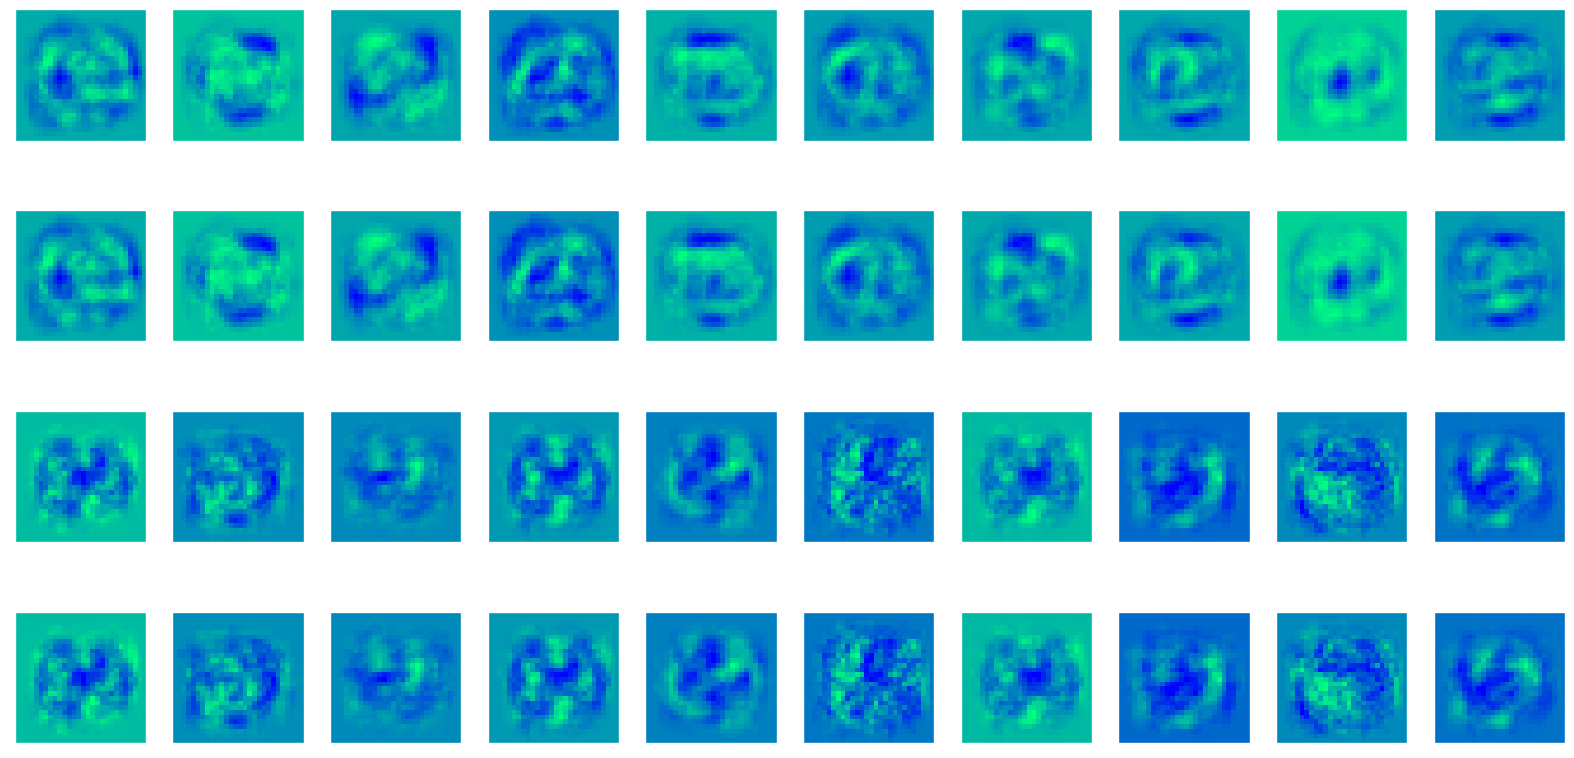

In [79]:
fig, ax = plt.subplots(4, 10, figsize=(20, 10))
for i in range(2):
    for j in range(10):
        ax[i, j].imshow(w1[train_sample[j]].reshape(28, 28), cmap='winter')
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i + 2, j].imshow(nn_weight[train_sample[j]].reshape(28, 28), cmap='winter')
        ax[i + 2, j].set_xticks([])
        ax[i + 2, j].set_yticks([])
fig.savefig('../assets/features.png')

# Result

## Bar Chart of average loss on every digit

In [80]:
def digit_extract(data):
    digits = dict()
    for i in range(10):
        digits[i] = get_index_digit(i, data)
    return digits

In [81]:
train_digits, test_digits = digit_extract(y_train), digit_extract(y_test)

In [82]:
nn.forward_prop(x_train)
train_output = nn.get_output()
nn.forward_prop(x_test)
test_output = nn.get_output()

In [83]:
def get_dataset_error(x, x_out, digits):
    errors = dict()
    for i in range(10):
        errors[i] = get_error_digit(x, x_out, digits[i])
    return errors

In [84]:
ERROR_TRAIN, ERROR_TEST = get_dataset_error(x_train, train_output, train_digits), get_dataset_error(x_test, test_output, test_digits)

In [85]:
ERROR_TEST

{0: 1.683780189862955,
 1: 0.8870725162583197,
 2: 2.105703789248815,
 3: 1.8345854565632622,
 4: 1.5538420684563186,
 5: 1.7321326824923984,
 6: 1.843896234242981,
 7: 1.6166680035337055,
 8: 2.1520255502529575,
 9: 1.6351227178320749}

In [86]:
total_train_error = sum(ERROR_TRAIN.values())
total_test_error = sum(ERROR_TEST.values())

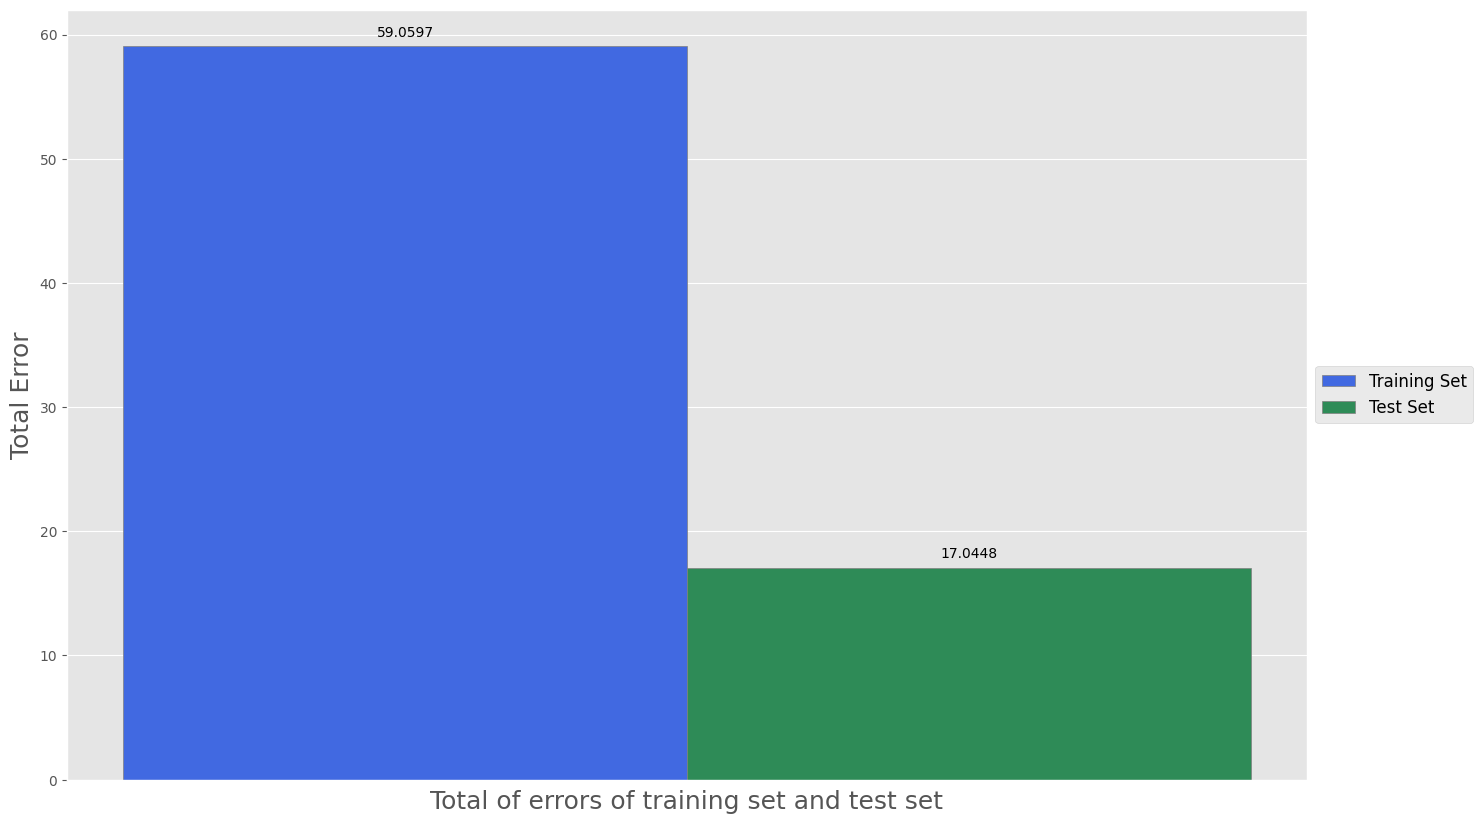

In [87]:
train_set = tuple([total_train_error])
test_set = tuple([total_test_error])


fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
labels = [f'{i}' for i in range(10)]

rect1 = ax.bar(1-0.5, train_set, width=0.5, color='royalblue',label='Training Set', align='edge', edgecolor ='grey')
rect2 = ax.bar(1, test_set, width=0.5, color='seagreen',label='Test Set', align='edge',edgecolor ='grey')

ax.bar_label(rect1, padding=5)
ax.bar_label(rect2, padding=5)
ax.set_xticks([])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 12})
plt.xlabel('Total of errors of training set and test set', fontsize=18)
plt.ylabel('Total Error', fontsize=18)
fig.savefig('../assets/total_loss.png')

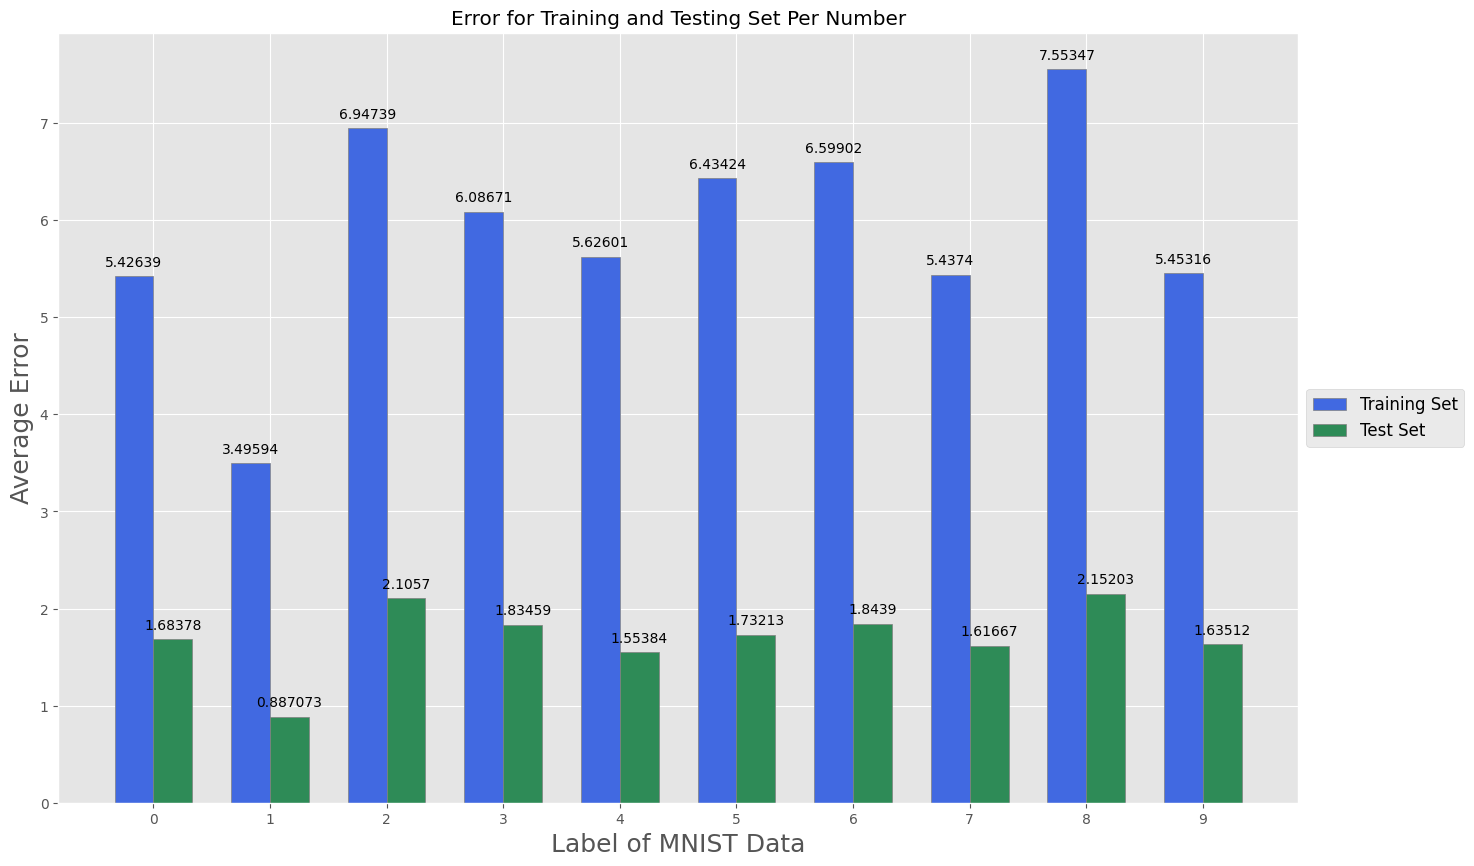

In [88]:
train_set = tuple(ERROR_TRAIN.values())
test_set = tuple(ERROR_TEST.values())
index = list(ERROR_TEST.keys())

width = np.min(np.diff(index)) / 3

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
labels = [f'{i}' for i in range(10)]

rect1 = ax.bar(index - width, train_set, width=width, color='royalblue',label='Training Set', align='edge', edgecolor ='grey')
rect2 = ax.bar(index, test_set, width=width, color='seagreen',label='Test Set', align='edge',edgecolor ='grey')
ax.set_xticks(index, labels)
ax.bar_label(rect1, padding=5)
ax.bar_label(rect2, padding=5)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 12})
plt.xlabel('Label of MNIST Data', fontsize=18)
plt.ylabel('Average Error', fontsize=18)
plt.title('Error for Training and Testing Set Per Number')
fig.savefig('../assets/average_loss.png')

## Time series of training error

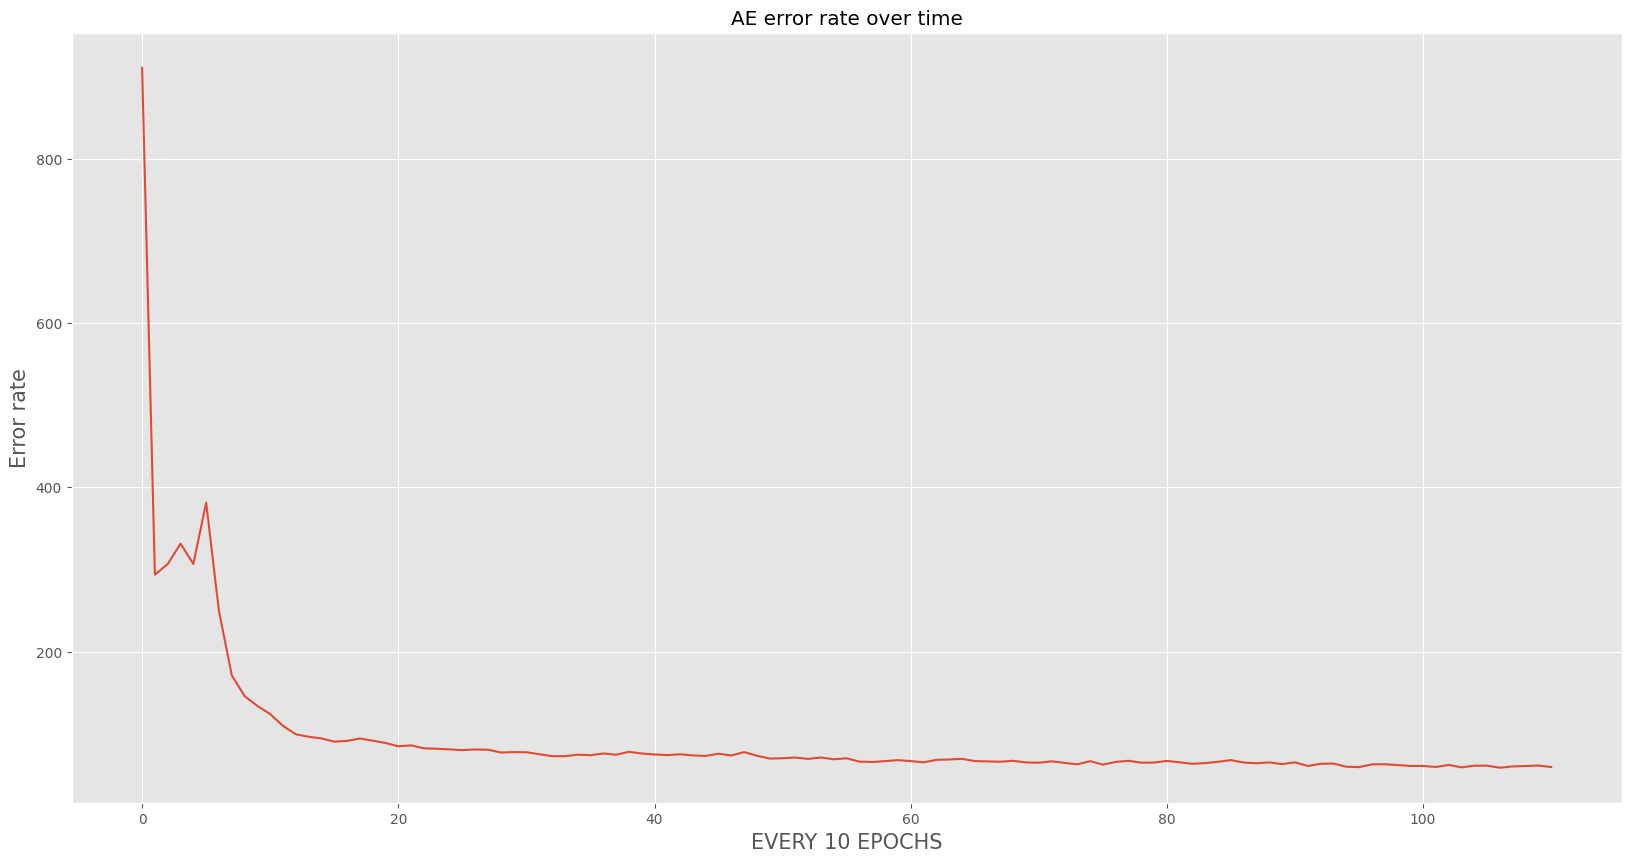

In [89]:
# Time series of error rate overtime
fig = plt.figure(figsize=(20, 10))
plt.plot(training_errors)
plt.title('AE error rate over time')
plt.xlabel('EVERY 10 EPOCHS', fontsize=15)
plt.ylabel('Error rate', fontsize=15)
fig.savefig('../assets/autoencoder_error.png')

In [90]:
nn.forward_prop(x_train)
w1, w2 = nn.get_weight()

np.savetxt('../assets/auto_weight_jk_nn.txt', w1)
np.savetxt('../assets/auto_weight_ij_nn.txt', w2)